In [1]:
import numpy as np
import gymnasium as gym
import torch
import torch.nn as nn
import torch.optim as optim
import time
from tqdm.notebook import tqdm
import os
import cv2

device=torch.device("cuda" if torch.cuda.is_available() else "cpu")
dtype = torch.float

# Environment Wrapper

In [2]:
class Atari_Wrapper(gym.Wrapper):
    # env wrapper to resize images, grey scale and frame stacking and other misc.
    
    def __init__(self, env, env_name, k, dsize=(84,84), use_add_done=False):
        super(Atari_Wrapper, self).__init__(env)
        self.dsize = dsize
        self.k = k
        self.use_add_done = use_add_done
        
        # set image cutout depending on game
        if "SpaceInvaders" in env_name:
            self.frame_cutout_h = (25,-7)
            self.frame_cutout_w = (7,-7)
        else:
            # no cutout
            self.frame_cutout_h = (0,-1)
            self.frame_cutout_w = (0,-1)
        
    def reset(self):
    
        self.Return = 0
        self.last_life_count = 0
        
        ob, _ = self.env.reset()
        ob = self.preprocess_observation(ob)
        
        # stack k times the reset ob
        self.frame_stack = np.stack([ob for i in range(self.k)])
        
        return self.frame_stack
    
    
    def step(self, action): 
        # do k frameskips, same action for every intermediate frame
        # stacking k frames
        
        reward = 0
        done = False
        additional_done = False
        
        # k frame skips or end of episode
        frames = []
        for i in range(self.k):
            
            ob, r, d, prova, info = self.env.step(action)
            
            # insert a (additional) done, when agent loses a life (Games with lives)
            if self.use_add_done:
                if info['lives'] < self.last_life_count:
                    additional_done = True  
                self.last_life_count = info['lives']
            
            ob = self.preprocess_observation(ob)
            frames.append(ob)
            
            # add reward
            reward += r
            
            if d: # env done
                done = True
                break
                       
        # build the observation
        self.step_frame_stack(frames)
        
        # add info, get return of the completed episode
        self.Return += reward
        if done:
            info["return"] = self.Return
            
        return self.frame_stack, reward, done, additional_done, info
    
    def step_frame_stack(self, frames):
        
        num_frames = len(frames)
        
        if num_frames == self.k:
            self.frame_stack = np.stack(frames)
        elif num_frames > self.k:
            self.frame_stack = np.array(frames[-self.k::])
        else: # mostly used when episode ends 
            
            # shift the existing frames in the framestack to the front=0 (0->k, index is time)
            self.frame_stack[0: self.k - num_frames] = self.frame_stack[num_frames::]
            # insert the new frames into the stack
            self.frame_stack[self.k - num_frames::] = np.array(frames)  
            
    def preprocess_observation(self, ob):
    # resize and grey and cutout image

        ob = cv2.cvtColor(ob[self.frame_cutout_h[0]:self.frame_cutout_h[1],
                           self.frame_cutout_w[0]:self.frame_cutout_w[1]], cv2.COLOR_BGR2GRAY)
        ob = cv2.resize(ob, dsize=self.dsize)
    
        return ob

# Network

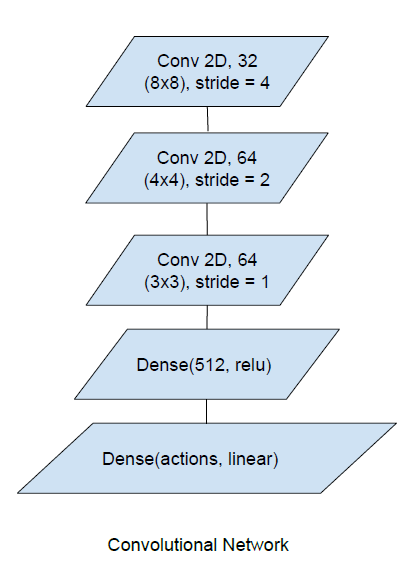

In [3]:
class DQN(nn.Module):
    
    def __init__(self, in_channels, num_actions):
        super().__init__()
        
        network = [
            torch.nn.Conv2d(in_channels, 32, kernel_size=8, stride=4, padding=0),
            nn.ReLU(),
            torch.nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=0),
            nn.ReLU(),
            torch.nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=0),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(64*7*7,512),
            nn.ReLU(),
            nn.Linear(512, num_actions)
        ]
        
        self.network = nn.Sequential(*network)
    
    def forward(self, x):
        actions = self.network(x)
        return actions

class Agent(nn.Module):
    
    def __init__(self, in_channels, num_actions, epsilon):
        super().__init__()
        
        self.in_channels = in_channels
        self.num_actions = num_actions
        self.network = DQN(in_channels, num_actions)
        
        self.eps = epsilon
    
    def forward(self, x):
        actions = self.network(x)
        return actions
    
    def e_greedy(self, x):
        
        actions = self.forward(x)
        
        greedy = torch.rand(1)
        if self.eps < greedy:
            return torch.argmax(actions)
        else:
            return (torch.rand(1) * self.num_actions).type('torch.LongTensor')[0] 
    
    def set_epsilon(self, epsilon):
        self.eps = epsilon

# ER and other classes

In [4]:
class Experience_Replay():

    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def insert(self, transitions):
        
        for i in range(len(transitions)):
            if len(self.memory) < self.capacity:
                self.memory.append(None)
            self.memory[self.position] = transitions[i]
            self.position = (self.position + 1) % self.capacity

    def get(self, batch_size):
        #return random.sample(self.memory, batch_size)
        indexes = (np.random.rand(batch_size) * (len(self.memory)-1)).astype(int)
        return [self.memory[i] for i in indexes]

    def __len__(self):
        return len(self.memory)

class Env_Runner:
    
    def __init__(self, env, agent):
        super().__init__()
        
        self.env = env
        self.agent = agent
        
        self.ob = self.env.reset()
        self.total_steps = 0
        
    def run(self, steps):
        
        obs = []
        actions = []
        rewards = []
        dones = []
        
        for step in range(steps):
            
            self.ob = torch.tensor(self.ob) # uint8
            action = self.agent.e_greedy(
                self.ob.to(device).to(dtype).unsqueeze(0) / 255) # float32+norm
            action = action.detach().cpu().numpy()
            
            obs.append(self.ob)
            actions.append(action)
            
            self.ob, r, done, additional_done, info = self.env.step(action)
               
            if done: # real environment reset, other add_dones are for q learning purposes
                self.ob = self.env.reset()
            
            rewards.append(r)
            dones.append(done or additional_done)
            
        self.total_steps += steps
                                    
        return obs, actions, rewards, dones
    
def make_transitions(obs, actions, rewards, dones):
    
    tuples = []

    steps = len(obs) - 1
    for t in range(steps):
        tuples.append((obs[t],
                       actions[t],
                       rewards[t],
                       obs[t+1],
                       int(not dones[t])))
        
    return tuples

def create_dir(path):
    if not os.path.exists(path):
        os.mkdir(path)

# Hyper Parameters

In [5]:
env_name = 'SpaceInvaders-v5' # 'Qbert-v5'
network_name = 'DDQN'

# hyperparameter
num_stacked_frames = 4

replay_memory_size = 250 
min_replay_size_to_update = 25

if env_name == 'Spaceinvaders-v5':
    lr = 6e-5 # SpaceInvaders
else:
    lr = 2.5e-4 # Qbert and others
gamma = 0.99
minibatch_size = 32
steps_rollout = 16
updating_steps = 4 

start_eps = 1
final_eps = 0.1

final_eps_frame = 10000
total_steps = 200000   

target_net_update = 100

save_model_steps = 5000

# Training

In [6]:
training = False
if training:
    # init
    raw_env = gym.make(f'ALE/{env_name}')
    env = Atari_Wrapper(raw_env, env_name, num_stacked_frames, use_add_done=True)

    in_channels = num_stacked_frames
    num_actions = env.action_space.n

    eps_interval = start_eps-final_eps

    agent = Agent(in_channels, num_actions, start_eps).to(device)
    target_agent = Agent(in_channels, num_actions, start_eps).to(device)
    target_agent.load_state_dict(agent.state_dict())

    replay = Experience_Replay(replay_memory_size)
    runner = Env_Runner(env, agent)
    optimizer = optim.Adam(agent.parameters(), lr=lr)
    huber_loss = torch.nn.SmoothL1Loss()

    num_steps = 0
    num_model_updates = 0

    loss_values = []
    cum_rew = []

    pbar = tqdm(desc='Training', total=total_steps)

    while num_steps < total_steps:
        
        # set agent exploration | cap exploration after x timesteps to final epsilon
        new_epsilon = np.maximum(final_eps, start_eps - ( eps_interval * num_steps/final_eps_frame))
        agent.set_epsilon(new_epsilon)
        
        # get data
        obs, actions, rewards, dones = runner.run(steps_rollout)
        transitions = make_transitions(obs, actions, rewards, dones)
        replay.insert(transitions)
        
        # add
        num_steps += steps_rollout
        pbar.update(steps_rollout)
        
        # check if update
        if num_steps < min_replay_size_to_update:
            continue
        
        # update
        for update in range(4):
            optimizer.zero_grad()
            
            minibatch = replay.get(minibatch_size)
            
            # uint8 to float32 and normalize to 0-1
            obs = (torch.stack([i[0] for i in minibatch]).to(device).to(dtype)) / 255 
            
            actions = np.stack([i[1] for i in minibatch])
            rewards = torch.tensor([i[2] for i in minibatch]).to(device)
            
            # uint8 to float32 and normalize to 0-1
            next_obs = (torch.stack([i[3] for i in minibatch]).to(device).to(dtype)) / 255
            
            dones = torch.tensor([i[4] for i in minibatch]).to(device)
            
            #  *** double dqn ***
            # prediction
            
            Qs = agent(torch.cat([obs, next_obs]))
            obs_Q, next_obs_Q = torch.split(Qs, minibatch_size ,dim=0)
            
            obs_Q = obs_Q[range(minibatch_size), actions]
            
            # target
            
            next_obs_Q_max = torch.max(next_obs_Q,1)[1].detach()

            target_Q = target_agent(next_obs)[range(minibatch_size), next_obs_Q_max].detach()
            
            target = rewards + gamma * target_Q * (1-dones)

            # loss
            loss = huber_loss(obs_Q, target) 
            
            loss_values.append(loss.item())
            epoch_rew = sum(rewards)
            cum_rew.append(epoch_rew)

            loss.backward()
            optimizer.step()
            
        num_model_updates += 1
        
        # update target network
        if num_model_updates%target_net_update == 0:
            target_agent.load_state_dict(agent.state_dict())
        
        # save the dqn after some time
        if num_steps%save_model_steps < steps_rollout:
            torch.save(agent,f"{network_name}_checkpoints/{network_name}-{num_steps}-{env_name}.pt")

    pbar.close()
    env.close()

# Save Training Info

In [7]:
if training:
    train_folder = 'train_info'
    create_dir(train_folder)

    # computing and saving the training info
    with open(f'{train_folder}/training_loss_{network_name}_{num_steps}-{env_name}.txt', 'w') as f:
        for el in loss_values:
            f.write(f'{el}\n')

    with open(f'{train_folder}/cumulative_reward_{network_name}_{num_steps}-{env_name}.txt', 'w') as f:
        for el in cum_rew:
            f.write(f'{el}\n')

# Evaluation

In [ ]:
rendering = True
render = 'human' if rendering else 'rgb_array'

# watch
if training:
    agent_name = f"{network_name}-{num_steps}-{env_name}.pt"
    torch.save(agent,agent_name)
    agent = torch.load(agent_name)
else:
   agent_name = f"{network_name}-{total_steps}-{env_name}.pt"
   agent = torch.load(f"{network_name}_checkpoints/{agent_name}")
   print(agent_name)

raw_env = gym.make(f'ALE/{env_name}', render_mode=render)
env = Atari_Wrapper(raw_env, env_name, num_stacked_frames)

steps = 5000
ob = env.reset()
agent.set_epsilon(0.025)
agent.eval()
imgs = []
return_values = []
for step in tqdm(range(steps)):
            
    action = agent.e_greedy(torch.tensor(ob, dtype=dtype).unsqueeze(0).to(device) / 255)
    action = action.detach().cpu().numpy()

    env.render()
    ob, _, done, _, info = env.step(action)
    
    if rendering:
        time.sleep(0.016)

    if done:
        ob = env.reset()
        return_values.append(info['return'])
        print(info)
    
    imgs.append(ob)
    
env.close()

## Computing mean result

In [ ]:
eval_folder = 'eval_returns'
create_dir(eval_folder)

with open(f'{eval_folder}/{agent_name}.txt', 'w') as f:
  for el in return_values:
    f.write(f'{el}\n')

mean_return_value = np.mean(return_values)
print(mean_return_value)
with open(f'{eval_folder}/{agent_name}_mean_return.txt', 'w') as f:
    f.write(str(mean_return_value))